In [1]:
from neo_access import *
from get_response_prop import placeAxesOnGrid
#from get_response_prop import calculate_bandwidth,response_detection_core#,build_pdf
import numpy as np
import matplotlib.pyplot as plt
from neo.io import PickleIO
import pandas as pd
import os
import seaborn as sns


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
def detect_cusum(x, threshold=1, drift=0, ending=False):
	"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

	Parameters
	----------
	x : 1D array_like
		data.
	threshold : positive number, optional (default = 1)
		amplitude threshold for the change in the data.
	drift : positive number, optional (default = 0)
		drift term that prevents any change in the absence of change.
	ending : bool, optional (default = False)
		True (1) to estimate when the change ends; False (0) otherwise.
	show : bool, optional (default = True)
		True (1) plots data in matplotlib figure, False (0) don't plot.
	ax : a matplotlib.axes.Axes instance, optional (default = None).

	Returns
	-------
	ta : 1D array_like [indi, indf], int
		alarm time (index of when the change was detected).
	tai : 1D array_like, int
		index of when the change started.
	taf : 1D array_like, int
		index of when the change ended (if `ending` is True).
	amp : 1D array_like, float
		amplitude of changes (if `ending` is True).

	Notes
	-----
	Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
	Start with a very large `threshold`.
	Choose `drift` to one half of the expected change, or adjust `drift` such
	that `g` = 0 more than 50% of the time.
	Then set the `threshold` so the required number of false alarms (this can
	be done automatically) or delay for detection is obtained.
	If faster detection is sought, try to decrease `drift`.
	If fewer false alarms are wanted, try to increase `drift`.
	If there is a subset of the change times that does not make sense,
	try to increase `drift`.

	Note that by default repeated sequential changes, i.e., changes that have
	the same beginning (`tai`) are not deleted because the changes were
	detected by the alarm (`ta`) at different instants. This is how the
	classical CUSUM algorithm operates.

	If you want to delete the repeated sequential changes and keep only the
	beginning of the first sequential change, set the parameter `ending` to
	True. In this case, the index of the ending of the change (`taf`) and the
	amplitude of the change (or of the total amplitude for a repeated
	sequential change) are calculated and only the first change of the repeated
	sequential changes is kept. In this case, it is likely that `ta`, `tai`,
	and `taf` will have less values than when `ending` was set to False.

	See this IPython Notebook [2]_.

	References
	----------
	.. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
	.. [2] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

	Examples
	--------
	>>> from detect_cusum import detect_cusum
	>>> x = np.random.randn(300)/5
	>>> x[100:200] += np.arange(0, 4, 4/100)
	>>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

	>>> x = np.random.randn(300)
	>>> x[100:200] += 6
	>>> detect_cusum(x, 4, 1.5, True, True)

	>>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
	>>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
	"""

	x = np.atleast_1d(x).astype('float64')
	gp, gn = np.zeros(x.size), np.zeros(x.size)
	ta, tai, taf = np.array([[], [], []], dtype=int)
	tap, tan = 0, 0
	amp = np.array([])
	# Find changes (online form)
	for i in range(1, x.size):
		s = x[i] - x[i-1]
		gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
		gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
		if gp[i] < 0:
			gp[i], tap = 0, i
		if gn[i] < 0:
			gn[i], tan = 0, i
		if gp[i] > threshold or gn[i] > threshold:  # change detected!
			ta = np.append(ta, i)    # alarm index
			tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
			gp[i], gn[i] = 0, 0      # reset alarm
	# THE CLASSICAL CUSUM ALGORITHM ENDS HERE

	# Estimation of when the change ends (offline form)
	if tai.size and ending:
		_, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
		taf = x.size - tai2[::-1] - 1
		# Eliminate repeated changes, changes that have the same beginning
		tai, ind = np.unique(tai, return_index=True)
		ta = ta[ind]
		# taf = np.unique(taf, return_index=False)  # corect later
		if tai.size != taf.size:
			if tai.size < taf.size:
				taf = taf[[np.argmax(taf >= i) for i in ta]]
			else:
				ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
				ta = ta[ind]
				tai = tai[ind]
		# Delete intercalated changes (the ending of the change is after
		# the beginning of the next change)
		ind = taf[:-1] - tai[1:] > 0
		if ind.any():
			ta = ta[~np.append(False, ind)]
			tai = tai[~np.append(False, ind)]
			taf = taf[~np.append(ind, False)]
		# Amplitude of changes
		amp = x[taf] - x[tai]

	return ta, tai, taf, amp,gp,gn


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
	"""Plot results of the detect_cusum function, see its help."""

	try:
		import matplotlib.pyplot as plt
	except ImportError:
		print('matplotlib is not available.')
	else:
		t = range(x.size)
		ax.plot(t, x, 'b-', lw=2)
		if len(ta):
			ax.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
					 label='Start')
			if ending:
				ax.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
						 label='Ending')
			ax.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
					 label='Alarm')
			ax.legend(loc='best', framealpha=.5, numpoints=1)
		ax.set_xlim(-.01*x.size, x.size*1.01-1)
		#ax.set_xlabel('Data #', fontsize=14)
		ax.set_ylabel('Amplitude', fontsize=14)
		ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
		yrange = ymax - ymin if ymax > ymin else 1
		ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
		ax.set_title('Time series and detected changes ' +
					  '(threshold= %.3g, drift= %.3g): N changes = %d'
					  % (threshold, drift, len(tai)))
		ax.margins(x=0)
		#plt.tight_layout()
		#plt.show()


In [3]:
wd = 'D:/Work/Recordings/DATA/Neuropixel/190803/2019-08-03_16-03-02/SpikeSortingResults_Probe2'
trials = 25
sweeplength = 20
samplerate = 30000



os.chdir(wd)
io = PickleIO(filename="PoT_block_20190803.pkl")
blk2 = io.read()[0]
dataframe = pd.read_pickle(os.path.join(wd,'PoT_block_df_20190803.pkl'))
selection = dataframe
data = get_all_data(blk2,selection,raster=True,timestamps=False,spikes=False,aisignal=False)


['0_0', '0_0', '0_0', '0_0']
['0_1', '0_1', '0_0', '0_1']
['0_2', '0_2', '0_0', '0_2']
['0_3', '0_3', '0_0', '0_3']
['0_4', '0_4', '0_0', '0_4']
['0_5', '0_5', '0_0', '0_5']
['0_6', '0_6', '0_0', '0_6']
['0_7', '0_7', '0_0', '0_7']
['0_8', '0_8', '0_0', '0_8']
['0_9', '0_9', '0_0', '0_9']
['0_10', '0_10', '0_0', '0_10']
['0_11', '0_0', '0_1', '0_0']
['0_12', '0_1', '0_1', '0_1']
['0_13', '0_2', '0_1', '0_2']
['0_14', '0_3', '0_1', '0_3']
['0_15', '0_4', '0_1', '0_4']
['0_16', '0_5', '0_1', '0_5']
['0_17', '0_6', '0_1', '0_6']
['0_18', '0_7', '0_1', '0_7']
['0_19', '0_8', '0_1', '0_8']
['0_20', '0_9', '0_1', '0_9']
['0_21', '0_10', '0_1', '0_10']
['0_22', '0_0', '0_2', '0_0']
['0_23', '0_1', '0_2', '0_1']
['0_24', '0_2', '0_2', '0_2']
['0_25', '0_3', '0_2', '0_3']
['0_26', '0_4', '0_2', '0_4']
['0_27', '0_5', '0_2', '0_5']
['0_28', '0_6', '0_2', '0_6']
['0_29', '0_7', '0_2', '0_7']
['0_30', '0_8', '0_2', '0_8']
['0_31', '0_9', '0_2', '0_9']
['0_32', '0_10', '0_2', '0_10']
['0_33', '0_0'

['0_515', '0_9', '0_46', '0_9']
['0_516', '0_10', '0_46', '0_10']
['0_517', '0_0', '0_47', '0_0']
['0_518', '0_1', '0_47', '0_1']
['0_519', '0_2', '0_47', '0_2']
['0_520', '0_3', '0_47', '0_3']
['0_521', '0_4', '0_47', '0_4']
['0_522', '0_5', '0_47', '0_5']
['0_523', '0_6', '0_47', '0_6']
['0_524', '0_7', '0_47', '0_7']
['0_525', '0_8', '0_47', '0_8']
['0_526', '0_9', '0_47', '0_9']
['0_527', '0_10', '0_47', '0_10']
['0_528', '0_0', '0_48', '0_0']
['0_529', '0_1', '0_48', '0_1']
['0_530', '0_2', '0_48', '0_2']
['0_531', '0_3', '0_48', '0_3']
['0_532', '0_4', '0_48', '0_4']
['0_533', '0_5', '0_48', '0_5']
['0_534', '0_6', '0_48', '0_6']
['0_535', '0_7', '0_48', '0_7']
['0_536', '0_8', '0_48', '0_8']
['0_537', '0_9', '0_48', '0_9']
['0_538', '0_10', '0_48', '0_10']
['0_539', '0_0', '0_49', '0_0']
['0_540', '0_1', '0_49', '0_1']
['0_541', '0_2', '0_49', '0_2']
['0_542', '0_3', '0_49', '0_3']
['0_543', '0_4', '0_49', '0_4']
['0_544', '0_5', '0_49', '0_5']
['0_545', '0_6', '0_49', '0_6']
['

['0_1022', '0_10', '0_92', '0_10']
['0_1023', '0_0', '0_93', '0_0']
['0_1024', '0_1', '0_93', '0_1']
['0_1025', '0_2', '0_93', '0_2']
['0_1026', '0_3', '0_93', '0_3']
['0_1027', '0_4', '0_93', '0_4']
['0_1028', '0_5', '0_93', '0_5']
['0_1029', '0_6', '0_93', '0_6']
['0_1030', '0_7', '0_93', '0_7']
['0_1031', '0_8', '0_93', '0_8']
['0_1032', '0_9', '0_93', '0_9']
['0_1033', '0_10', '0_93', '0_10']
['0_1034', '0_0', '0_94', '0_0']
['0_1035', '0_1', '0_94', '0_1']
['0_1036', '0_2', '0_94', '0_2']
['0_1037', '0_3', '0_94', '0_3']
['0_1038', '0_4', '0_94', '0_4']
['0_1039', '0_5', '0_94', '0_5']
['0_1040', '0_6', '0_94', '0_6']
['0_1041', '0_7', '0_94', '0_7']
['0_1042', '0_8', '0_94', '0_8']
['0_1043', '0_9', '0_94', '0_9']
['0_1044', '0_10', '0_94', '0_10']
['0_1045', '0_0', '0_95', '0_0']
['0_1046', '0_1', '0_95', '0_1']
['0_1047', '0_2', '0_95', '0_2']
['0_1048', '0_3', '0_95', '0_3']
['0_1049', '0_4', '0_95', '0_4']
['0_1050', '0_5', '0_95', '0_5']
['0_1051', '0_6', '0_95', '0_6']
['0_

['0_1502', '0_6', '0_136', '0_6']
['0_1503', '0_7', '0_136', '0_7']
['0_1504', '0_8', '0_136', '0_8']
['0_1505', '0_9', '0_136', '0_9']
['0_1506', '0_10', '0_136', '0_10']
['0_1507', '0_0', '0_137', '0_0']
['0_1508', '0_1', '0_137', '0_1']
['0_1509', '0_2', '0_137', '0_2']
['0_1510', '0_3', '0_137', '0_3']
['0_1511', '0_4', '0_137', '0_4']
['0_1512', '0_5', '0_137', '0_5']
['0_1513', '0_6', '0_137', '0_6']
['0_1514', '0_7', '0_137', '0_7']
['0_1515', '0_8', '0_137', '0_8']
['0_1516', '0_9', '0_137', '0_9']
['0_1517', '0_10', '0_137', '0_10']
['0_1518', '0_0', '0_138', '0_0']
['0_1519', '0_1', '0_138', '0_1']
['0_1520', '0_2', '0_138', '0_2']
['0_1521', '0_3', '0_138', '0_3']
['0_1522', '0_4', '0_138', '0_4']
['0_1523', '0_5', '0_138', '0_5']
['0_1524', '0_6', '0_138', '0_6']
['0_1525', '0_7', '0_138', '0_7']
['0_1526', '0_8', '0_138', '0_8']
['0_1527', '0_9', '0_138', '0_9']
['0_1528', '0_10', '0_138', '0_10']
['0_1529', '0_0', '0_139', '0_0']
['0_1530', '0_1', '0_139', '0_1']
['0_1531

['0_1980', '0_0', '0_180', '0_0']
['0_1981', '0_1', '0_180', '0_1']
['0_1982', '0_2', '0_180', '0_2']
['0_1983', '0_3', '0_180', '0_3']
['0_1984', '0_4', '0_180', '0_4']
['0_1985', '0_5', '0_180', '0_5']
['0_1986', '0_6', '0_180', '0_6']
['0_1987', '0_7', '0_180', '0_7']
['0_1988', '0_8', '0_180', '0_8']
['0_1989', '0_9', '0_180', '0_9']
['0_1990', '0_10', '0_180', '0_10']
['0_1991', '0_0', '0_181', '0_0']
['0_1992', '0_1', '0_181', '0_1']
['0_1993', '0_2', '0_181', '0_2']
['0_1994', '0_3', '0_181', '0_3']
['0_1995', '0_4', '0_181', '0_4']
['0_1996', '0_5', '0_181', '0_5']
['0_1997', '0_6', '0_181', '0_6']
['0_1998', '0_7', '0_181', '0_7']
['0_1999', '0_8', '0_181', '0_8']
['0_2000', '0_9', '0_181', '0_9']
['0_2001', '0_10', '0_181', '0_10']
['0_2002', '0_0', '0_182', '0_0']
['0_2003', '0_1', '0_182', '0_1']
['0_2004', '0_2', '0_182', '0_2']
['0_2005', '0_3', '0_182', '0_3']
['0_2006', '0_4', '0_182', '0_4']
['0_2007', '0_5', '0_182', '0_5']
['0_2008', '0_6', '0_182', '0_6']
['0_2009',

['0_2458', '0_5', '0_223', '0_5']
['0_2459', '0_6', '0_223', '0_6']
['0_2460', '0_7', '0_223', '0_7']
['0_2461', '0_8', '0_223', '0_8']
['0_2462', '0_9', '0_223', '0_9']
['0_2463', '0_10', '0_223', '0_10']
['0_2464', '0_0', '0_224', '0_0']
['0_2465', '0_1', '0_224', '0_1']
['0_2466', '0_2', '0_224', '0_2']
['0_2467', '0_3', '0_224', '0_3']
['0_2468', '0_4', '0_224', '0_4']
['0_2469', '0_5', '0_224', '0_5']
['0_2470', '0_6', '0_224', '0_6']
['0_2471', '0_7', '0_224', '0_7']
['0_2472', '0_8', '0_224', '0_8']
['0_2473', '0_9', '0_224', '0_9']
['0_2474', '0_10', '0_224', '0_10']
['0_2475', '0_0', '0_225', '0_0']
['0_2476', '0_1', '0_225', '0_1']
['0_2477', '0_2', '0_225', '0_2']
['0_2478', '0_3', '0_225', '0_3']
['0_2479', '0_4', '0_225', '0_4']
['0_2480', '0_5', '0_225', '0_5']
['0_2481', '0_6', '0_225', '0_6']
['0_2482', '0_7', '0_225', '0_7']
['0_2483', '0_8', '0_225', '0_8']
['0_2484', '0_9', '0_225', '0_9']
['0_2485', '0_10', '0_225', '0_10']
['0_2486', '0_0', '0_226', '0_0']
['0_2487

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


['0_2896', '0_3', '0_263', '0_3']
['0_2897', '0_4', '0_263', '0_4']
['0_2898', '0_5', '0_263', '0_5']
['0_2899', '0_6', '0_263', '0_6']
['0_2900', '0_7', '0_263', '0_7']
['0_2901', '0_8', '0_263', '0_8']
['0_2902', '0_9', '0_263', '0_9']
['0_2903', '0_10', '0_263', '0_10']
['0_2904', '0_0', '0_264', '0_0']
['0_2905', '0_1', '0_264', '0_1']
['0_2906', '0_2', '0_264', '0_2']
['0_2907', '0_3', '0_264', '0_3']
['0_2908', '0_4', '0_264', '0_4']
['0_2909', '0_5', '0_264', '0_5']
['0_2910', '0_6', '0_264', '0_6']
['0_2911', '0_7', '0_264', '0_7']
['0_2912', '0_8', '0_264', '0_8']
['0_2913', '0_9', '0_264', '0_9']
['0_2914', '0_10', '0_264', '0_10']
['0_2915', '0_0', '0_265', '0_0']
['0_2916', '0_1', '0_265', '0_1']
['0_2917', '0_2', '0_265', '0_2']
['0_2918', '0_3', '0_265', '0_3']
['0_2919', '0_4', '0_265', '0_4']
['0_2920', '0_5', '0_265', '0_5']
['0_2921', '0_6', '0_265', '0_6']
['0_2922', '0_7', '0_265', '0_7']
['0_2923', '0_8', '0_265', '0_8']
['0_2924', '0_9', '0_265', '0_9']
['0_2925',

['0_3374', '0_8', '0_306', '0_8']
['0_3375', '0_9', '0_306', '0_9']
['0_3376', '0_10', '0_306', '0_10']
['0_3377', '0_0', '0_307', '0_0']
['0_3378', '0_1', '0_307', '0_1']
['0_3379', '0_2', '0_307', '0_2']
['0_3380', '0_3', '0_307', '0_3']
['0_3381', '0_4', '0_307', '0_4']
['0_3382', '0_5', '0_307', '0_5']
['0_3383', '0_6', '0_307', '0_6']
['0_3384', '0_7', '0_307', '0_7']
['0_3385', '0_8', '0_307', '0_8']
['0_3386', '0_9', '0_307', '0_9']
['0_3387', '0_10', '0_307', '0_10']
['0_3388', '0_0', '0_308', '0_0']
['0_3389', '0_1', '0_308', '0_1']
['0_3390', '0_2', '0_308', '0_2']
['0_3391', '0_3', '0_308', '0_3']
['0_3392', '0_4', '0_308', '0_4']
['0_3393', '0_5', '0_308', '0_5']
['0_3394', '0_6', '0_308', '0_6']
['0_3395', '0_7', '0_308', '0_7']
['0_3396', '0_8', '0_308', '0_8']
['0_3397', '0_9', '0_308', '0_9']
['0_3398', '0_10', '0_308', '0_10']
['0_3399', '0_0', '0_309', '0_0']
['0_3400', '0_1', '0_309', '0_1']
['0_3401', '0_2', '0_309', '0_2']
['0_3402', '0_3', '0_309', '0_3']
['0_3403

['0_3852', '0_2', '0_350', '0_2']
['0_3853', '0_3', '0_350', '0_3']
['0_3854', '0_4', '0_350', '0_4']
['0_3855', '0_5', '0_350', '0_5']
['0_3856', '0_6', '0_350', '0_6']
['0_3857', '0_7', '0_350', '0_7']
['0_3858', '0_8', '0_350', '0_8']
['0_3859', '0_9', '0_350', '0_9']
['0_3860', '0_10', '0_350', '0_10']
['0_3861', '0_0', '0_351', '0_0']
['0_3862', '0_1', '0_351', '0_1']
['0_3863', '0_2', '0_351', '0_2']
['0_3864', '0_3', '0_351', '0_3']
['0_3865', '0_4', '0_351', '0_4']
['0_3866', '0_5', '0_351', '0_5']
['0_3867', '0_6', '0_351', '0_6']
['0_3868', '0_7', '0_351', '0_7']
['0_3869', '0_8', '0_351', '0_8']
['0_3870', '0_9', '0_351', '0_9']
['0_3871', '0_10', '0_351', '0_10']


In [4]:
def bin_data(data, bin_size):
    data = data.reshape(data.shape[0], -1, bin_size)
    data = np.sum(data, axis=2)
    return data 

def build_pdf(times_cut,start,end,samplingrate=30000,kernel = 'gaussian',bw = None):
   
	x = np.arange(start*samplingrate/30,end*samplingrate/30)[:, np.newaxis]
	times_cut = np.sort(times_cut)
	# Gaussian KDE
	kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(times_cut[:, np.newaxis])
	log_dens = kde.score_samples(x)
	pdf = np.exp(log_dens)

	return pdf

def cut_data(selection,data,start_rel = None,end_rel = None,trials = None,samplingrate = None):
	
	'''function needs df row as input. also data needs to be 1d
		start_rel & end_rel means relative to stimulus start'''
	
	start = selection.pre -start_rel
	end =  selection.pre +end_rel
	
	
	raster = np.zeros([trials,int((end-start)*samplingrate)])
	times = (data[:,1]/samplingrate)
	times_inx = data[:,0]
	times_cut = ((times[(times> start)&(times< end)]*samplingrate)-start*samplingrate).astype(int)
	times_inx_cut = times_inx[(times> start)&(times< end)].astype(int)
	raster[times_inx_cut,times_cut] = 1
	#cumsum_trials = np.cumsum(raster,axis=1)
	cumsum = np.sum((np.cumsum(raster,axis=1)),axis = 0)
	
	return raster,np.sort(times_cut),cumsum

def plot_PSTH_gaussian(selection, raster,samplingrate=30000,start_rel=None,end_rel=None,stimstart = None, binsize=None,bandwidth = None):
    # selection needs to be row of dataframe
    # bandwith = ms
    # binsize = ms
    # stimstart = ms
    #from get_response_prop import calculate_bandwidth,response_detection_core
    def bin_data(data, bin_size):
        data = data.reshape(data.shape[0], -1, bin_size)
        data = np.sum(data, axis=2)
        return data 

    def build_pdf(times_cut,start,end,samplingrate=30000,kernel = 'gaussian',bw = None):

        x = np.arange(start*samplingrate/30,end*samplingrate/30)[:, np.newaxis]
        times_cut = np.sort(times_cut)
        # Gaussian KDE
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(times_cut[:, np.newaxis])
        log_dens = kde.score_samples(x)
        pdf = np.exp(log_dens)

        return pdf
    
    def response_detection_core(pdf,stimstart = 1,thr = 2):

        baseline = np.mean(pdf[:stimstart*1000])

        max_response = np.max(pdf)
        print(max_response)
        min_response = np.min(pdf)    
        thr_ex = 2
        thr_inh = -2

        width_ex = np.argmax(pdf)+(250)
        width_inh = np.argmin(pdf)+(250)

        if width_ex > pdf.size:
            width = pdf.size-np.argmax(pdf)

        if (max_response > thr_ex) & (np.mean(pdf[np.argmax(pdf):int(width_ex)]) > thr_ex):
            return 'responsive excitation'

        elif (min_response < thr_inh) & (np.mean(pdf[np.argmin(pdf):int(width_inh)]) < thr_inh):
            return 'responsive inhibition'

        else:
            return 'non_responsive'
    trials = raster.shape[0]
    
    data_bin = bin_data(raster,int(0.001*samplingrate))
    
    spk = np.sort(np.where(data_bin==1)[1])
    pdf = build_pdf(spk,start_rel,end_rel,bw=int(15))
    
    a = np.asanyarray(pdf)
    mns = a[:stimstart].mean()
    sstd = a[:stimstart].std()

    z_score = (a - mns) / sstd

    bins = np.arange(start_rel*1000,end_rel*1000,binsize)
    x_grid = np.arange(start_rel*1000,end_rel*1000,)
    response = response_detection_core(z_score,stimstart = stimstart)
    
    fig, ax1 = plt.subplots()
    ax1.plot(x_grid, z_score, linewidth=3, alpha=0.5, label='bw=%.1f // binsize=%.1f' % (bandwidth,binsize))
    ax2 = ax1.twinx()
    ax2.hist(spk, bins, fc='gray', histtype='stepfilled', alpha=0.3)
    #ax1.legend(loc='upper left')

    if response != 'responsive':   
        ax1.set_title(str(selection.expID)+'//'+str(selection.cluster)+response)
    else:
        ax1.set_title(str(selection.expID)+'//'+str(selection.cluster)+response)

    plt.show()
    plt.close()
    
    

    return z_score,response,fig


<IPython.core.display.Javascript object>


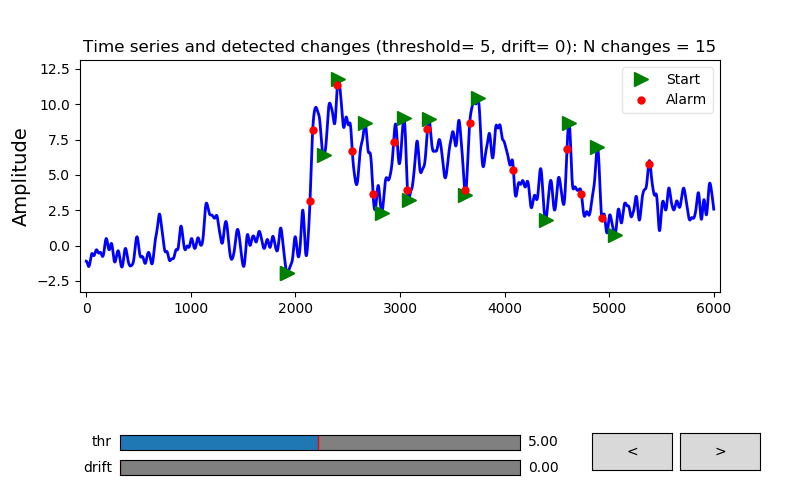

0

In [33]:
% matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig = plt.figure(figsize=(8,5))

ax = placeAxesOnGrid(fig,yspan=[0, 0.8] )
plt.subplots_adjust(left=0.1, bottom=0.3)

thr0 =5
drift0 = 0.0

'''ta, tai, taf, amp,gp,gn = detect_cusum(pdf, threshold=thr0, drift=drift0, ending=False)

_plot(pdf, thr0, drift0, None, ax, ta, tai, taf, gp, gn)'''

axcolor = 'grey'
axdrift = plt.axes([0.15, 0.05, 0.5, 0.03], facecolor=axcolor)
axthr = plt.axes([0.15, 0.1, 0.5, 0.03], facecolor=axcolor)

sdrift = Slider(axdrift, 'drift', 0, 0.5, valinit=drift0, valstep=0.001)
sthr = Slider(axthr, 'thr', 0.1, 10, valinit=thr0, valstep=0.001)

axnext = plt.axes([0.85, 0.06, 0.1, 0.075],facecolor=axcolor)
bnext = Button(axnext, '>')

axprev = plt.axes([0.74, 0.06, 0.1, 0.075],facecolor=axcolor)
bprev = Button(axprev, '<')

starts = {}

class Index(object):
    
    def __init__(self):
        self.pdf = 0
        self.start = None
    ind = 32
    #starts_tmp = []
    #sdrift.reset()
    #sthr.reset()
    
    def next1(self, event):
        
        
        drift_storage = [drift0]
        thr_storage = [thr0]
        ax.clear()
        
         
        self.ind += 1
        i = self.ind
        dat = np.sort(data[0][i])
        sel = selection.iloc[i]
        raster,times,cumsum = cut_data(sel,dat,start_rel = 9, end_rel = 11, trials =int(sel.trials),samplingrate=30000 )
        pdf,response,fig = plot_PSTH_gaussian(sel, raster,samplingrate=30000,start_rel=7,end_rel=13,
                                              stimstart = 2000, binsize=150,bandwidth = 50)
        ta, tain, taf, amp,gp,gn = detect_cusum(pdf, threshold=thr0, drift=drift0, ending=False)
        _plot(pdf, thr0, drift0, None, ax, ta, tain, taf, gp, gn)
        #fig.canvas.draw_idle()
        
        self.pdf = pdf
        self.start = tain
        return self.pdf, self.start
    
    
    def update(self,val):
        
        ax.cla()
        drift = sdrift.val
        thr = sthr.val

        ta, tai, taf, amp,gp,gn = detect_cusum(self.pdf, threshold=thr, drift=drift, ending=False)
        _plot(self.pdf, thr, drift, None, ax, ta, tai, taf, gp, gn)

        starts[str(i)] = tai
        fig.canvas.draw_idle()
        print(tai)
        self.start = 1
        self.pdf = 1
        return self.start, self.pdf
        
        
        
        
        
        
callback = Index()
bnext.on_clicked(callback.next1)
sthr.on_changed(callback.update)
sdrift.on_changed(callback.update)
  



<IPython.core.display.Javascript object>


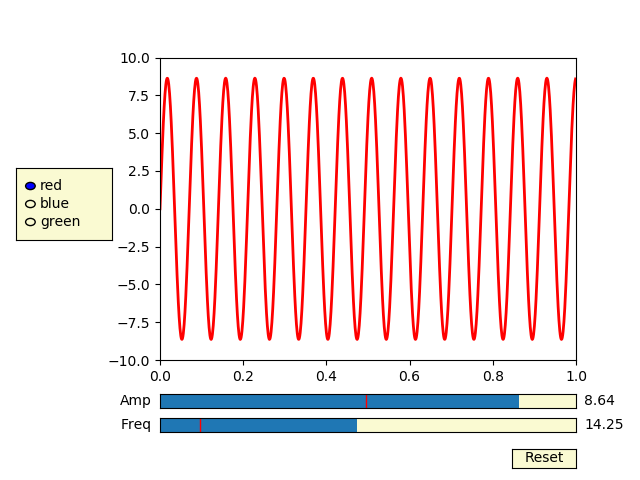

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
class test(object):
    def __init__(self):

        self.fig, ax = plt.subplots()
        plt.subplots_adjust(left=0.25, bottom=0.25)
        self.t = np.arange(0.0, 1.0, 0.001)
        a0 = 5
        f0 = 3
        s = a0*np.sin(2*np.pi*f0*self.t)
        self.l, = plt.plot(self.t, s, lw=2, color='red')
        plt.axis([0, 1, -10, 10])

        axcolor = 'lightgoldenrodyellow'
        axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
        axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

        self.sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0)
        self.samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)
        self.sfreq.on_changed(self.update)
        self.samp.on_changed(self.update)

        resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
        self.button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
        self.button.on_clicked(self.reset)

        rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
        self.radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)
        self.radio.on_clicked(self.colorfunc)

        plt.show()

    def update(self,val):
        amp = self.samp.val
        freq = self.sfreq.val
        self.l.set_ydata(amp*np.sin(2*np.pi*freq*self.t))
        self.fig.canvas.draw_idle()

    def reset(self, event):
        self.sfreq.reset()
        self.samp.reset()

    def colorfunc(self, label):
        self.l.set_color(label)
        self.fig.canvas.draw_idle()

test1 = test()

In [11]:
test1.sfreq.val

3

In [16]:
dicts = {}

In [26]:
dicts["latency"] = [1.2,5,'string']


In [27]:
dicts

{'latency': [1.2, 5, 'string'], 'peak': 34, 'test': 1, 'test2': 34}

In [20]:
dicts

{'test': 1, 'test2': 34}

In [21]:
dicts.keys()

dict_keys(['test', 'test2'])

In [30]:
dicts_df = pd.DataFrame.from_dict(dicts, orient ='index')

In [31]:
dicts_df

,0
test,1
test2,34
latency,"[1.2, 5, string]"
peak,34
